In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# 加载经验数据
print("Loading empirical data...")
w_media_empirical = pd.read_csv('./new_output/empirical/w_media_risk_data_7days.csv')
o_people_empirical = pd.read_csv('./new_output/empirical/sentiment_data_7days.csv')
m_media_empirical = pd.read_csv('./new_output/empirical/m_media_risk_data_7days.csv')

# 创建经验数据字典
emp_w_risk_p = dict(zip(w_media_empirical['period_id_3d'], w_media_empirical['risk_p']))
emp_m_risk_p = dict(zip(m_media_empirical['period_id_3d'], m_media_empirical['risk_p']))
emp_sentiment_high_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['high_p']))
emp_sentiment_middle_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['middle_p']))
emp_sentiment_low_p = dict(zip(o_people_empirical['period_id_3d'], o_people_empirical['low_p']))


empirical_data = {
    'w_risk_p': emp_w_risk_p,
    'm_risk_p': emp_m_risk_p,
    'sentiment_high_p': emp_sentiment_high_p,
    'sentiment_middle_p': emp_sentiment_middle_p,
    'sentiment_low_p': emp_sentiment_low_p
}

# 设置随机种子确保可重复性
np.random.seed(42)

# 加载网络
from src.modules import *
print("Loading network...")
network = joblib.load('networks/simple_all_new.pkl')
print("Network loaded successfully")


Loading empirical data...
Loading network...
Network loaded successfully


In [ ]:
# from src.VariantABCSimulator import VariantABCSimulator
# # 3. 测试仅同质性影响变体
# print("\n=== Testing Homophily Only Model ===")
# homophily_abc = VariantABCSimulator(
#     empirical_data=empirical_data,
#     model_type='homophily_only',
#     n_particles=50,
#     n_iterations=5
# )
# results_homophily = homophily_abc.run_abc()

# print("\nBest parameters for Homophily Only Model:")
# for param, value in results_homophily['best_params'].items():
#     print(f"{param}: {value:.4f}")
# print(f"Best error: {results_homophily['best_error']:.4f}")


In [12]:
import joblib
from src.other_modules import NoMainstreamModel, NoWeMediaModel, HomophilyOnlyModel
from src.utils.utils import calculate_error_detailed
from src.modules import *
from src.other_modules import process_history, calculate_error_detailed

In [3]:
homophily_results = joblib.load('output/other_model/homophily_results.pkl')
homophily_params = homophily_results['best_params']

no_mainstream_results = joblib.load('output/other_model/no_mainstream_results.pkl')
no_mainstream_params = no_mainstream_results['best_params']

no_wemedia_results = joblib.load('output/other_model/no_wemedia_results.pkl')
no_wemedia_params = no_wemedia_results['best_params']

In [4]:
network = joblib.load('networks/simple_all_new.pkl')
model = HomophilyOnlyModel(network)
# 设置初始状态并执行模拟
homophily_history = model.simulate_steps(steps=96, **homophily_params)
network = joblib.load('networks/simple_all_new.pkl')
model = NoMainstreamModel(network)
no_mainstream_history = model.simulate_steps(steps=96, **no_mainstream_params)

network = joblib.load('networks/simple_all_new.pkl')
model = NoWeMediaModel(network)
no_wemedia_history = model.simulate_steps(steps=96, **no_wemedia_params)

e:\newdesktop\archive\论文投稿\ssci发表计划\新冠后遗症\project\src\modules.py:36: RuntimeWarning: invalid value encountered in divide
  probs = values / np.sum(values)


In [13]:
import pickle
import pandas as pd
with open('abc_results/abc_results.pkl', 'rb') as f:
    abc_results = pickle.load(f)
best_params = abc_results['best_params']
# 加载网络
print("Loading network...")
network = joblib.load('networks/simple_all_new.pkl')
# 在运行模拟之前设置属性
setattr(network, 't', 0)
setattr(network, 'history', [])
print("Network loaded successfully")

# 运行模拟
print("Starting simulation...")
csdag_history = network.simulate_steps(
    steps=96,
    **best_params
)
print("Simulation completed")


Loading network...
Network loaded successfully
Starting simulation...
Simulation completed


In [15]:
homophily_avg_result = process_history(homophily_history)
no_mainstream_avg_result = process_history(no_mainstream_history)
no_wemedia_avg_result = process_history(no_wemedia_history)
csdag_avg_result = process_history(csdag_history)
homophily_error_detailed = calculate_error_detailed(homophily_avg_result, empirical_data)
no_mainstream_error_detailed = calculate_error_detailed(no_mainstream_avg_result, empirical_data)
no_wemedia_error_detailed = calculate_error_detailed(no_wemedia_avg_result, empirical_data)
csdag_error_detailed = calculate_error_detailed(csdag_avg_result, empirical_data)

In [ ]:
# 准备模型数据
models_data = {
    'CSDAG': csdag_avg_result,
    'Homophily': homophily_avg_result,
    'No Mainstream': no_mainstream_avg_result,
    'No WeMedia': no_wemedia_avg_result
}

# 准备经验数据
empirical_data = {
    'sentiment_high_p': emp_sentiment_high_p,
    'sentiment_middle_p': emp_sentiment_middle_p,
    'sentiment_low_p': emp_sentiment_low_p
}

In [36]:
def calculate_dynamic_metrics(model_data, empirical_data):
    """
    计算模型的动态响应指标
    
    Returns:
        Dict: 包含各种动态指标的结果
    """
    metrics = {}
    
    # 1. 趋势一致性 (计算相邻时间点的变化方向是否一致)
    def trend_consistency(pred, real):
        pred_diff = np.diff([v for v in pred.values()])
        real_diff = np.diff([v for v in real.values()])
        consistency = np.mean((pred_diff * real_diff) > 0)
        return consistency
    
    # 2. 波动幅度相似度 (比较标准差)
    def volatility_similarity(pred, real):
        pred_std = np.std(list(pred.values()))
        real_std = np.std(list(real.values()))
        return 1 - abs(pred_std - real_std) / max(pred_std, real_std)
    
    # 3. 响应延迟 (使用互相关来计算时间延迟)
    def response_lag(pred, real):
        pred_vals = np.array(list(pred.values()))
        real_vals = np.array(list(real.values()))
        correlation = np.correlate(pred_vals - np.mean(pred_vals), 
                                 real_vals - np.mean(real_vals), 
                                 mode='full')
        lag = np.argmax(correlation) - (len(pred_vals) - 1)
        return abs(lag)  # 返回绝对延迟值
    
    emotion_types = ['sentiment_high_p', 'sentiment_middle_p', 'sentiment_low_p']
    
    for emotion in emotion_types:
        metrics[emotion] = {
            'trend_consistency': trend_consistency(model_data[emotion], empirical_data[emotion]),
            'volatility_similarity': volatility_similarity(model_data[emotion], empirical_data[emotion]),
            'response_lag': response_lag(model_data[emotion], empirical_data[emotion])
        }
    
    return metrics

# 计算所有模型的动态指标
models_metrics = {}
for model_name, model_data in models_data.items():
    models_metrics[model_name] = calculate_dynamic_metrics(model_data, empirical_data)

C:\Users\wujlin\AppData\Local\Temp\ipykernel_8000\561277763.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


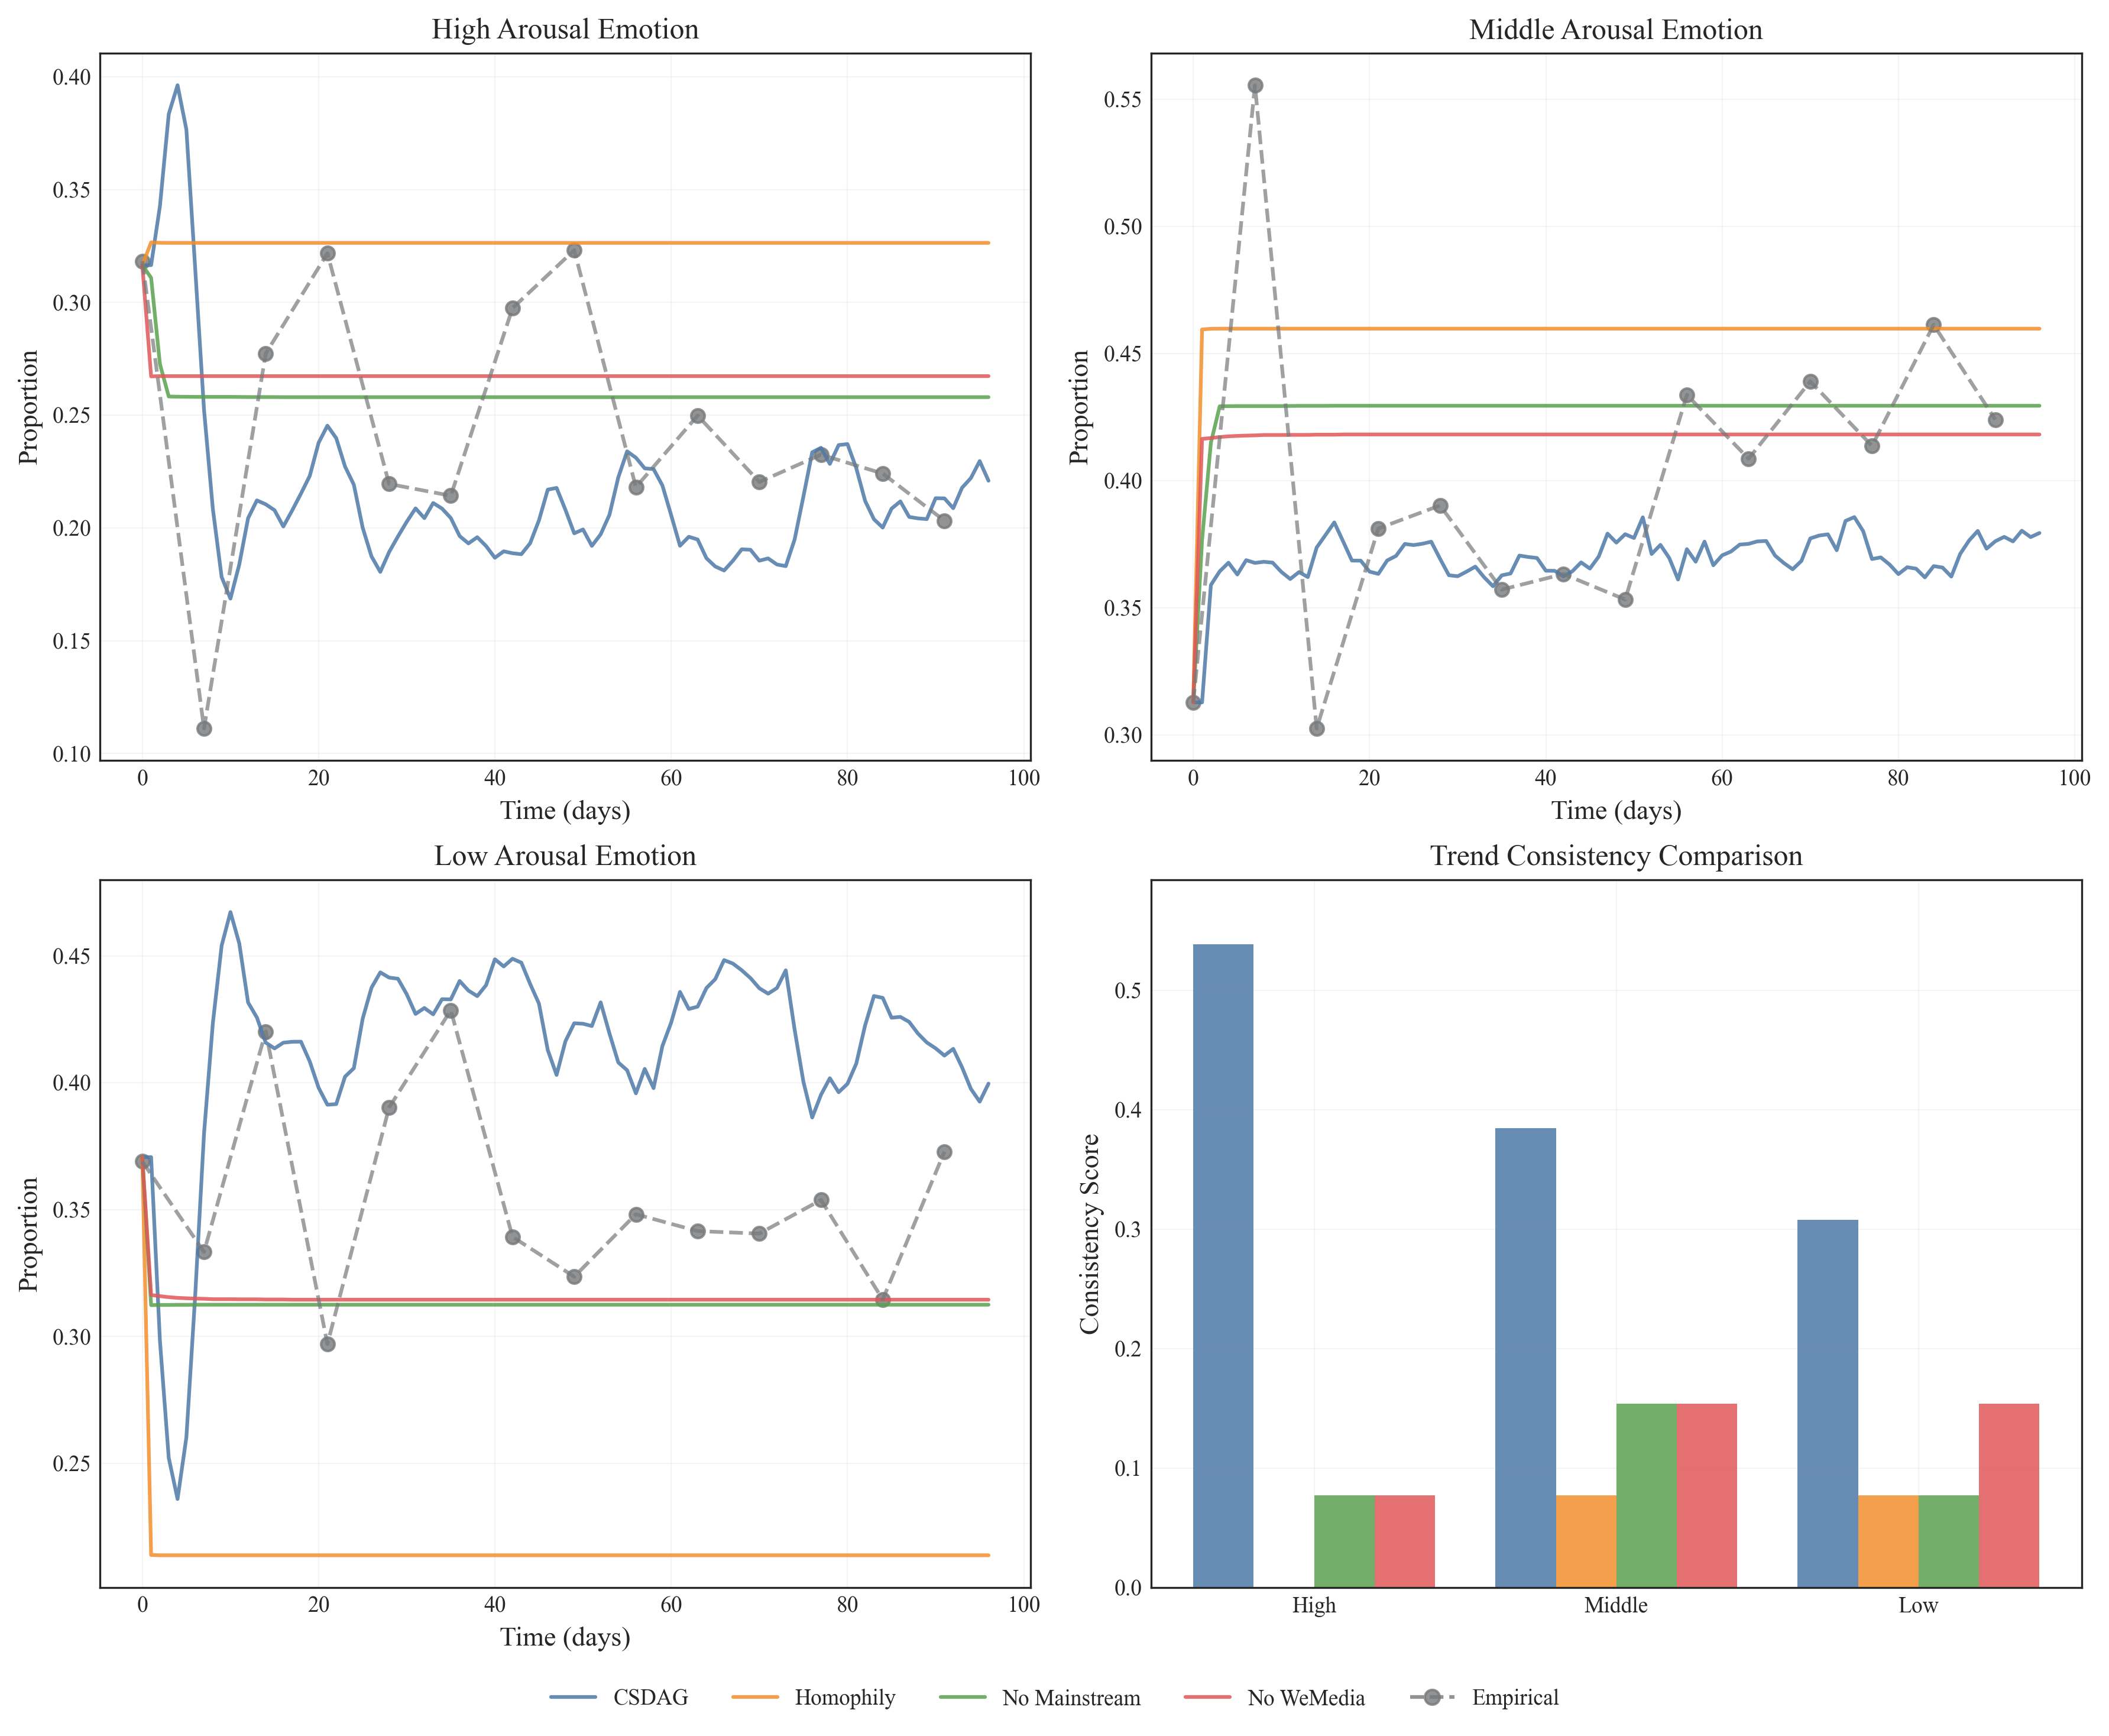

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 定义明亮优雅的配色方案
COLOR_PALETTE = {
    'csdag': '#4e79a7',      # 明亮的蓝色
    'homophily': '#f28e2b',  # 温暖的橙色
    'no_mainstream': '#59a14f',  # 清新的绿色
    'no_wemedia': '#e15759',  # 柔和的红色
    'empirical': '#76787a'   # 中性灰色
}

# 创建图形和子图
fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 设置全局样式
plt.style.use('seaborn-white')
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5
})

# 绘制高唤醒情绪对比
ax = axs[0, 0]
time_steps = range(len(csdag_history))
ax.plot(time_steps, [step['o_people']['H'] for step in csdag_history], 
        color=COLOR_PALETTE['csdag'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['H'] for step in homophily_history], 
        color=COLOR_PALETTE['homophily'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['H'] for step in no_mainstream_history], 
        color=COLOR_PALETTE['no_mainstream'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['H'] for step in no_wemedia_history], 
        color=COLOR_PALETTE['no_wemedia'], alpha=0.85)

# 绘制经验数据散点和连线
weeks = sorted(empirical_data['sentiment_high_p'].keys())
emp_values = [empirical_data['sentiment_high_p'][w] for w in weeks]
ax.plot([w*7 for w in weeks], emp_values, 
        color=COLOR_PALETTE['empirical'], linestyle='--', alpha=0.7)
ax.scatter([w*7 for w in weeks], emp_values, 
          color=COLOR_PALETTE['empirical'], s=30, alpha=0.8)

ax.set_title('High Arousal Emotion')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Proportion')
ax.grid(True, alpha=0.2)

# 绘制中等唤醒情绪对比
ax = axs[0, 1]
ax.plot(time_steps, [step['o_people']['M'] for step in csdag_history], 
        color=COLOR_PALETTE['csdag'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['M'] for step in homophily_history], 
        color=COLOR_PALETTE['homophily'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['M'] for step in no_mainstream_history], 
        color=COLOR_PALETTE['no_mainstream'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['M'] for step in no_wemedia_history], 
        color=COLOR_PALETTE['no_wemedia'], alpha=0.85)

# 绘制经验数据散点和连线
weeks = sorted(empirical_data['sentiment_middle_p'].keys())
emp_values = [empirical_data['sentiment_middle_p'][w] for w in weeks]
ax.plot([w*7 for w in weeks], emp_values, 
        color=COLOR_PALETTE['empirical'], linestyle='--', alpha=0.7)
ax.scatter([w*7 for w in weeks], emp_values, 
          color=COLOR_PALETTE['empirical'], s=30, alpha=0.8)

ax.set_title('Middle Arousal Emotion')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Proportion')
ax.grid(True, alpha=0.2)

# 绘制低唤醒情绪对比
ax = axs[1, 0]
ax.plot(time_steps, [step['o_people']['L'] for step in csdag_history], 
        color=COLOR_PALETTE['csdag'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['L'] for step in homophily_history], 
        color=COLOR_PALETTE['homophily'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['L'] for step in no_mainstream_history], 
        color=COLOR_PALETTE['no_mainstream'], alpha=0.85)
ax.plot(time_steps, [step['o_people']['L'] for step in no_wemedia_history], 
        color=COLOR_PALETTE['no_wemedia'], alpha=0.85)

# 绘制经验数据散点和连线
weeks = sorted(empirical_data['sentiment_low_p'].keys())
emp_values = [empirical_data['sentiment_low_p'][w] for w in weeks]
ax.plot([w*7 for w in weeks], emp_values, 
        color=COLOR_PALETTE['empirical'], linestyle='--', alpha=0.7)
ax.scatter([w*7 for w in weeks], emp_values, 
          color=COLOR_PALETTE['empirical'], s=30, alpha=0.8)

ax.set_title('Low Arousal Emotion')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Proportion')
ax.grid(True, alpha=0.2)

# 在绘制误差对比柱状图的部分替换为 Trend Consistency
ax = axs[1, 1]

# 计算每个模型在不同情绪状态下的趋势一致性
emotions = ['High', 'Middle', 'Low']
x = np.arange(len(emotions))
width = 0.2

# 获取每个模型在不同情绪状态下的趋势一致性数据
csdag_trend = [
    models_metrics['CSDAG']['sentiment_high_p']['trend_consistency'],
    models_metrics['CSDAG']['sentiment_middle_p']['trend_consistency'],
    models_metrics['CSDAG']['sentiment_low_p']['trend_consistency']
]

homophily_trend = [
    models_metrics['Homophily']['sentiment_high_p']['trend_consistency'],
    models_metrics['Homophily']['sentiment_middle_p']['trend_consistency'],
    models_metrics['Homophily']['sentiment_low_p']['trend_consistency']
]

no_mainstream_trend = [
    models_metrics['No Mainstream']['sentiment_high_p']['trend_consistency'],
    models_metrics['No Mainstream']['sentiment_middle_p']['trend_consistency'],
    models_metrics['No Mainstream']['sentiment_low_p']['trend_consistency']
]

no_wemedia_trend = [
    models_metrics['No WeMedia']['sentiment_high_p']['trend_consistency'],
    models_metrics['No WeMedia']['sentiment_middle_p']['trend_consistency'],
    models_metrics['No WeMedia']['sentiment_low_p']['trend_consistency']
]

# 绘制分组柱状图
ax.bar(x - 1.5*width, csdag_trend, width, 
       color=COLOR_PALETTE['csdag'], alpha=0.85)
ax.bar(x - 0.5*width, homophily_trend, width, 
       color=COLOR_PALETTE['homophily'], alpha=0.85)
ax.bar(x + 0.5*width, no_mainstream_trend, width, 
       color=COLOR_PALETTE['no_mainstream'], alpha=0.85)
ax.bar(x + 1.5*width, no_wemedia_trend, width, 
       color=COLOR_PALETTE['no_wemedia'], alpha=0.85)

ax.set_title('Trend Consistency Comparison')
ax.set_ylabel('Consistency Score')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.grid(True, alpha=0.2)

# 调整 y 轴范围，使其从 0 开始
ax.set_ylim(0, max(max(csdag_trend), max(homophily_trend), 
                   max(no_mainstream_trend), max(no_wemedia_trend)) * 1.1)

# 创建统一的图例
handles = [
    plt.Line2D([], [], color=COLOR_PALETTE['csdag'], label='CSDAG', alpha=0.85),
    plt.Line2D([], [], color=COLOR_PALETTE['homophily'], label='Homophily', alpha=0.85),
    plt.Line2D([], [], color=COLOR_PALETTE['no_mainstream'], label='No Mainstream', alpha=0.85),
    plt.Line2D([], [], color=COLOR_PALETTE['no_wemedia'], label='No WeMedia', alpha=0.85),
    plt.Line2D([], [], color=COLOR_PALETTE['empirical'], linestyle='--', 
               marker='o', label='Empirical', alpha=0.8)
]

# 将图例放在图片下方
fig.legend(handles=handles,
          bbox_to_anchor=(0.5, 0.02), 
          loc='lower center', 
          ncol=5,
          frameon=False)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # 为底部图例留出空间
plt.savefig('graph/Figure 7.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
print(f'csdag_trend: {csdag_trend}')
print(f'homophily_trend: {homophily_trend}')
print(f'no_mainstream_trend: {no_mainstream_trend}')
print(f'no_wemedia_trend: {no_wemedia_trend}')


csdag_trend: [0.5384615384615384, 0.38461538461538464, 0.3076923076923077]
homophily_trend: [0.0, 0.07692307692307693, 0.07692307692307693]
no_mainstream_trend: [0.07692307692307693, 0.15384615384615385, 0.07692307692307693]
no_wemedia_trend: [0.07692307692307693, 0.15384615384615385, 0.15384615384615385]
